Noisy Student Training is a semi-supervised learning method which gives better results with less data. Noisy Student Training is based on the self-training framework and trained with 4 simple steps:

1. Train a classifier on labeled data (teacher).
2. Infer labels on a much larger unlabeled dataset.
3. Train a larger classifier on the combined set, adding noise (noisy student).
4. Go to step 2, with student as teacher

This requires TensorFlow 2.4 or higher, as well as TensorFlow Hub and TensorFlow
Models, which can be installed using the following command:


In [1]:
# !pip install -q tf-models-official tensorflow-addons
# ! pip install imgaug

## Imports and setup

In [29]:
import os
import tensorflow as tf
os.environ['CUDA_VISIBLE_DEVICES'] ='0,1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH']='true'

from imgaug.augmenters import RandAugment
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt   # For displaying the images
import numpy as np  # for some calculations
from skimage.io import imread #for reading images.....can also use opencv instead
from skimage.transform import resize  #for resizing of the images
from sklearn.model_selection import train_test_split
from matplotlib.pyplot import imshow
tf.random.set_seed(42)
import warnings; warnings.filterwarnings('ignore')

## Define hyperparameters

AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 16
EPOCHS =50

CROP_TO = 72
RESIZE_TO = 96

#images are in 2d form hence we need to convert it to 1D for so we use flatten()

target=[] #the output tells whether it is a sunflower or rugby ball or ice cream cone
images=[] #this the data which we have
flat_data=[] #flattened data for training the model

DATADIR = '../data/images'
CATEGORIES = ['yes', 'no']

In [3]:
# Now iterate through them to get the images
for category in CATEGORIES:
    class_num = CATEGORIES.index(category)  #label Encoding ie we take their index as the label
    path = os.path.join(DATADIR,category)   #create path to use all the images
    for img in os.listdir(path):
        img_array = imread(os.path.join(path,img))  # it gives all the values ie the 2d matrix of the image
        # To see image """
        #plt.imshow(img_array)
        #print(img_array.shape)
        #break
        #""""
        # Resize
        img_resized = resize(img_array,(150,150,3))
        # Flatten
        # flat_data.append(img_resized.flatten())
        images.append(img_resized)
        target.append(class_num)

In [4]:
flat_data = np.array(flat_data)
target = np.array(target)
images = np.array(images)

In [5]:
len(images)

251

In [6]:
x_train, x_test, y_train, y_test = train_test_split(images, target,test_size=0.3, random_state=109)
'''x_test = x_train
y_test = y_train'''
x_val = x_test
y_val = y_test

In [7]:
#imshow(x_train[9])

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(x_val.shape)
print(y_val.shape)

(175, 150, 150, 3)
(175,)
(76, 150, 150, 3)
(76,)
(76, 150, 150, 3)
(76,)


In [8]:
# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
# x_train = x_train[50,:,:,:]
# x_test = x_test[10,:,:,:]
# val_samples = 495
# new_train_x, new_y_train = x_train[: val_samples + 1], y_train[: val_samples + 1]
# val_x, val_y = x_train[val_samples:], y_train[val_samples:]

## Create TensorFlow `Dataset` objects

In [9]:
# Initialize `RandAugment` object with 2 layers of
# augmentation transforms and strength of 9.
augmenter = RandAugment(n=2, m=9)

For training the teacher model, we will only be using two geometric augmentation
transforms: random horizontal flip and random crop.

In [10]:
def preprocess_train(image, label, noisy=False):
    # print(image.shape)
    image = tf.image.random_flip_left_right(image)
    # We first resize the original image to a larger dimension
    # and then we take random crops from it.
    image = tf.image.resize(image, [RESIZE_TO, RESIZE_TO])
    image = tf.image.random_crop(image, [CROP_TO, CROP_TO, 3])
    if noisy:
        image = augmenter.distort(image)
    return image, label


def preprocess_test(image, label):
    image = tf.image.resize(image, [CROP_TO, CROP_TO])
    return image, label

In [11]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

2022-07-20 14:35:17.354889: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/abhay/karyashala/venv/lib/python3.10/site-packages/cv2/../../lib64:
2022-07-20 14:35:17.354929: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-20 14:35:17.354961: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ThinkCentre): /proc/driver/nvidia/version does not exist


We make sure `train_clean_ds` and `train_noisy_ds` are shuffled using the *same* seed to
ensure their orders are exactly the same. This will be helpful during training the
student model.

In [12]:
x_train[0].shape

(150, 150, 3)

In [13]:
# This dataset will be used to train the first model.
train_clean_ds = (
    train_ds.shuffle(BATCH_SIZE * 10, seed=42)
    .map(lambda x, y: (preprocess_train(x_train[0], y_train[0], noisy=False)), num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

In [14]:
# This prepares the `Dataset` object to use RandAugment.
train_noisy_ds = (
    train_ds.shuffle(BATCH_SIZE * 10, seed=42)
    .map(preprocess_train, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

validation_ds = (
    validation_ds.map(preprocess_test, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

test_ds = (
    test_ds.map(preprocess_test, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

In [15]:
# This dataset will be used to train the second model.
consistency_training_ds = tf.data.Dataset.zip((train_clean_ds, train_noisy_ds))

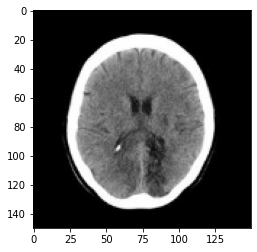

In [16]:
## Visualize the datasets

imshow(x_train[3])
plt.show()

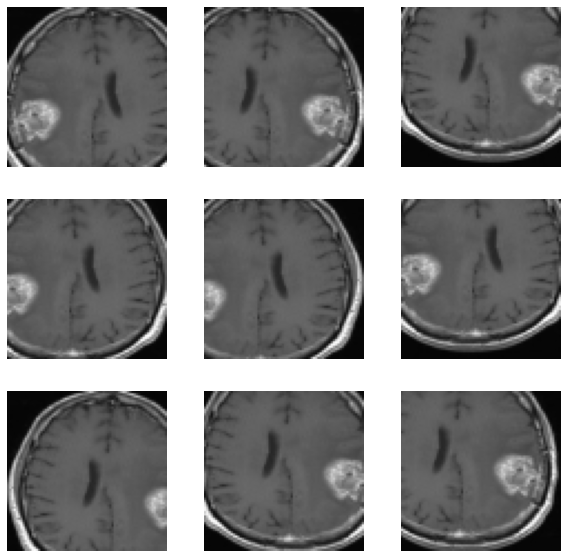

In [17]:
sample_images, sample_labels = next(iter(train_clean_ds))
plt.figure(figsize=(10, 10))
for i, image in enumerate(sample_images[:9]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.axis("off")

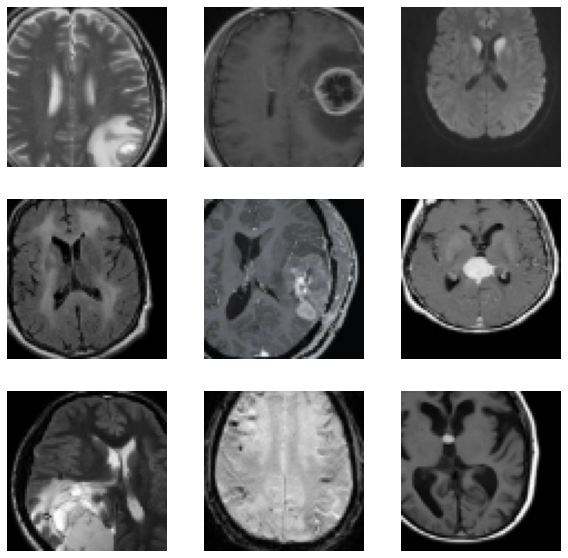

In [18]:
sample_images, sample_labels = next(iter(train_noisy_ds))
plt.figure(figsize=(10, 10))
for i, image in enumerate(sample_images[:9]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.axis("off")
plt.show()

## Define a model building utility function

We now define our model building utility. Our model is based on the [ResNet50V2 architecture](https://arxiv.org/abs/1603.05027).

In [19]:
def get_training_model(num_classes=10):
    resnet50_v2 = tf.keras.applications.ResNet50V2(
        weights=None, include_top=False, input_shape=(CROP_TO, CROP_TO, 3),
    )
    model = tf.keras.Sequential(
        [
            layers.Input((CROP_TO, CROP_TO, 3)),
            layers.Rescaling(scale=1.0 / 127.5, offset=-1),
            resnet50_v2,
            layers.GlobalAveragePooling2D(),
            layers.Dense(num_classes),
        ]
    )
    return model

In the interest of reproducibility, we serialize the initial random weights of the
teacher  network.

In [20]:
initial_teacher_model = get_training_model()
initial_teacher_model.save_weights("../models/initial_teacher_model.h5")

## Train the teacher model

As noted in Noisy Student Training, if the teacher model is trained with *geometric
ensembling* and when the student model is forced to mimic that, it leads to better
performance. The original work uses [Stochastic Depth](https://arxiv.org/abs/1603.09382)
and [Dropout](https://jmlr.org/papers/v15/srivastava14a.html) to bring in the ensembling
part but for this example, we will use [Stochastic Weight Averaging](https://arxiv.org/abs/1803.05407)
(SWA) which also resembles geometric ensembling.

In [21]:
# Define the callbacks.
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(patience=3)
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True
)

# Initialize SWA from tf-hub.
SWA = tfa.optimizers.SWA

In [22]:
# Compile and train the teacher model.
teacher_model = get_training_model()
teacher_model.load_weights("../models/initial_teacher_model.h5")
teacher_model.compile(
    # Notice that we are wrapping our optimizer within SWA
    optimizer=SWA(tf.keras.optimizers.Adam()),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [23]:
history = teacher_model.fit(
    train_clean_ds,
    epochs=EPOCHS,
    validation_data=validation_ds,
    callbacks=[reduce_lr, early_stopping],
)

teacher_model.save("../models/teacher_model.h5")

Epoch 1/50
11/11 [==============================] - 38s 2s/step - loss: 0.3881 - accuracy: 0.9086 - val_loss: 1.6959 - val_accuracy: 0.6447 - lr: 0.0010
Epoch 2/50
11/11 [==============================] - 20s 2s/step - loss: 1.0337e-05 - accuracy: 1.0000 - val_loss: 1.4496 - val_accuracy: 0.6447 - lr: 0.0010
Epoch 3/50
11/11 [==============================] - 20s 2s/step - loss: 7.9223e-07 - accuracy: 1.0000 - val_loss: 1.8936 - val_accuracy: 0.6447 - lr: 0.0010
Epoch 4/50
11/11 [==============================] - 20s 2s/step - loss: 3.8488e-07 - accuracy: 1.0000 - val_loss: 2.2670 - val_accuracy: 0.6447 - lr: 0.0010
Epoch 5/50
11/11 [==============================] - 20s 2s/step - loss: 2.5545e-07 - accuracy: 1.0000 - val_loss: 2.5031 - val_accuracy: 0.6447 - lr: 0.0010
Epoch 6/50
11/11 [==============================] - 20s 2s/step - loss: 2.3501e-07 - accuracy: 1.0000 - val_loss: 2.6387 - val_accuracy: 0.6447 - lr: 1.0000e-04
Epoch 7/50
11/11 [==============================] - 20s 2s

In [24]:
# Evaluate the teacher model on the test set.
_, acc = teacher_model.evaluate(test_ds, verbose=0)
#print(f"Test accuracy: {acc*100}%")
print("test accuracy:",acc*100)

test accuracy: 64.47368264198303


## Define a self-training utility

For this part, we will borrow the `Distiller` class from [this Keras Example](https://keras.io/examples/vision/knowledge_distillation/).


In [28]:
# Majority of the code is taken from:
# https://keras.io/examples/vision/knowledge_distillation/
class SelfTrainer(tf.keras.Model):
    def __init__(self, student, teacher):
        super(SelfTrainer, self).__init__()
        self.student = student
        self.teacher = teacher

    def compile(
        self, optimizer, metrics, student_loss_fn, distillation_loss_fn, temperature=3):
        super(SelfTrainer, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.temperature = temperature

    def train_step(self, data):
        # Since our dataset is a zip of two independent datasets,
        # after initially parsing them, we segregate the
        # respective images and labels next.
        clean_ds, noisy_ds = data
        clean_images, _ = clean_ds
        noisy_images, y = noisy_ds

        # Forward pass of teacher
        teacher_predictions = self.teacher(clean_images, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(noisy_images, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            total_loss = (student_loss + distillation_loss) / 2

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(total_loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`
        self.compiled_metrics.update_state(
            y, tf.nn.softmax(student_predictions, axis=1)
        )

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"total_loss": total_loss})
        return results

    def test_step(self, data):
        # During inference, we only pass a dataset consisting images and labels.
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Update the metrics
        self.compiled_metrics.update_state(y, tf.nn.softmax(y_prediction, axis=1))

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        return results

The only difference in this implementation is the way loss is being calculated. **Instead
of weighted the distillation loss and student loss differently we are taking their
average following Noisy Student Training**.

## Train the student model

In [26]:
# Define the callbacks.
# We are using a larger decay factor to stabilize the training.
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    patience=3, factor=0.5, monitor="val_accuracy"
)
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True, monitor="val_accuracy"
)

In [26]:
# Compile and train the student model.
self_trainer = SelfTrainer(student=get_training_model(), teacher=teacher_model)
self_trainer.compile(
    # Notice we are *not* using SWA here.
    optimizer="adam",
    metrics=["accuracy"],
    student_loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=tf.keras.losses.KLDivergence(),
    temperature=10,
)
history = self_trainer.fit(
    consistency_training_ds,
    epochs=EPOCHS,
    validation_data=validation_ds,
    callbacks=[reduce_lr],
)

self_trainer.save_weights("../models/self_trainer.h5")

Epoch 1/50
11/11 [==============================] - 31s 2s/step - accuracy: 0.5429 - total_loss: 0.5279 - val_accuracy: 0.3553 - lr: 0.0010
Epoch 2/50
11/11 [==============================] - 23s 2s/step - accuracy: 0.6057 - total_loss: 0.3844 - val_accuracy: 0.3553 - lr: 0.0010
Epoch 3/50
11/11 [==============================] - 23s 2s/step - accuracy: 0.5429 - total_loss: 0.3740 - val_accuracy: 0.6447 - lr: 0.0010
Epoch 4/50
11/11 [==============================] - 23s 2s/step - accuracy: 0.5657 - total_loss: 0.3843 - val_accuracy: 0.6447 - lr: 0.0010
Epoch 5/50
11/11 [==============================] - 23s 2s/step - accuracy: 0.5657 - total_loss: 0.3922 - val_accuracy: 0.6447 - lr: 0.0010
Epoch 6/50
11/11 [==============================] - 23s 2s/step - accuracy: 0.6114 - total_loss: 0.3595 - val_accuracy: 0.6447 - lr: 0.0010
Epoch 7/50
11/11 [==============================] - 24s 2s/step - accuracy: 0.6114 - total_loss: 0.3480 - val_accuracy: 0.6447 - lr: 5.0000e-04
Epoch 8/50
11/11

In [27]:
# Evaluate the student model.
acc = self_trainer.evaluate(test_ds, verbose=0)
print(f"Test accuracy from student model: {acc*100}%")

Test accuracy from student model: 64.47368264198303%
